# Support files

Italian Preprocessing

In [ ]:
import os
import shutil

# Paths
source_dir = "/content/drive/MyDrive/PD_DL_MainProject_2023-24/Haleem/Datasets/Italian New Dataset"
target_dir = "/content/drive/MyDrive/PD_DL_MainProject_2023-24/Haleem/Datasets/Italian Cleaned"

# Create cleaned folders
os.makedirs(os.path.join(target_dir, "HC"), exist_ok=True)
os.makedirs(os.path.join(target_dir, "PD"), exist_ok=True)

# Allowed audio formats
valid_exts = [".wav", ".mp3", ".flac"]

# Counter to assign new IDs
subject_counters = {"HC": 1, "PD": 1}

# Process each class
for cls in ["HC", "PD"]:
    class_src = os.path.join(source_dir, cls)
    class_dst = os.path.join(target_dir, cls)

    for subject_folder in sorted(os.listdir(class_src)):
        subject_path = os.path.join(class_src, subject_folder)
        if not os.path.isdir(subject_path):
            continue

        subject_id = f"{cls}_{subject_counters[cls]:03d}"
        file_counter = 1

        for file in sorted(os.listdir(subject_path)):
            ext = os.path.splitext(file)[1].lower()
            if ext in valid_exts:
                old_path = os.path.join(subject_path, file)
                new_filename = f"{subject_id}_{file_counter:02d}{ext}"
                new_path = os.path.join(class_dst, new_filename)
                shutil.copy2(old_path, new_path)
                file_counter += 1

        subject_counters[cls] += 1


sample rate

In [ ]:
import soundfile as sf
info = sf.info("/content/drive/MyDrive/PD_DL_MainProject_2023-24/Haleem/Datasets/Italian Cleaned/PD/PD_002_01.wav")
print(info.samplerate)


16000


Clip & Reduce

In [ ]:
import os
import librosa
import soundfile as sf
from tqdm import tqdm
import shutil
import random

# 🔹 Configuration
input_folder = "/content/drive/MyDrive/PD_DL_MainProject_2023-24/Haleem/Datasets/Italian Cleaned"  # Your dataset root with HC/ and PD/
output_folder = "/content/drive/MyDrive/PD_DL_MainProject_2023-24/Haleem/Datasets/Italian Clipped"  # To save all 3s clips
reduced_output = "/content/drive/MyDrive/PD_DL_MainProject_2023-24/Haleem/Datasets/Italian Reduced"  # Balanced 150/150 final dataset
target_duration = 3  # seconds
sr = 22050
target_files_per_class = 150

# Create output folders
os.makedirs(output_folder, exist_ok=True)
os.makedirs(f"{output_folder}/HC", exist_ok=True)
os.makedirs(f"{output_folder}/PD", exist_ok=True)

# 🔹 Step 1: Split WAVs into 3-sec clips
for class_label in ["HC", "PD"]:
    class_path = os.path.join(input_folder, class_label)
    files = [f for f in os.listdir(class_path) if f.lower().endswith(".wav")]

    for idx, filename in enumerate(tqdm(files, desc=f"Processing {class_label}")):
        file_path = os.path.join(class_path, filename)
        try:
            y, _ = librosa.load(file_path, sr=sr)
            target_samples = target_duration * sr
            num_clips = len(y) // target_samples

            if num_clips == 0:
                continue  # Skip short clips

            for i in range(num_clips):
                start = i * target_samples
                end = start + target_samples
                clip = y[start:end]

                clip_filename = f"{class_label}_{idx}_clip{i}.wav"
                sf.write(os.path.join(output_folder, class_label, clip_filename), clip, sr)

        except Exception as e:
            print(f"⚠️ Skipping {file_path} due to error: {e}")

# 🔹 Step 2: Select 150 clips per class for final dataset
os.makedirs(reduced_output, exist_ok=True)
for class_label in ["HC", "PD"]:
    src = os.path.join(output_folder, class_label)
    dst = os.path.join(reduced_output, class_label)
    os.makedirs(dst, exist_ok=True)

    all_files = [f for f in os.listdir(src) if f.endswith(".wav")]
    selected = random.sample(all_files, min(target_files_per_class, len(all_files)))

    for file in selected:
        shutil.copy(os.path.join(src, file), os.path.join(dst, file))

print("✅ Final dataset saved to:", reduced_output)


Processing PD: 100%|██████████| 437/437 [01:02<00:00,  7.01it/s]


✅ Final dataset saved to: /content/drive/MyDrive/PD_DL_MainProject_2023-24/Haleem/Datasets/Italian Reduced


Train-Test split

In [ ]:

import os
import shutil
import random
from collections import defaultdict
from tqdm import tqdm

# 🔹 Configuration
source_dir = "/content/drive/MyDrive/PD_DL_MainProject_2023-24/Haleem/Datasets/Italian dataset/Italian Cleaned"  # Contains: source_dir/HC/*.wav and source_dir/PD/*.wav
target_dir = "/content/drive/MyDrive/PD_DL_MainProject_2023-24/Haleem/Datasets/Italian dataset/Spllitted/Audio"  # Will contain: target_dir/train/HC, train/PD, test/HC, test/PD
split_ratio = 0.8

# 🔹 Create necessary directories
for split in ["train", "test"]:
    for cls in ["HC", "PD"]:
        os.makedirs(os.path.join(target_dir, split, cls), exist_ok=True)

# 🔹 Group files by subject
subject_files = {"HC": defaultdict(list), "PD": defaultdict(list)}

for cls in ["HC", "PD"]:
    class_path = os.path.join(source_dir, cls)
    for fname in os.listdir(class_path):
        if fname.endswith(".wav"):
            parts = fname.split("_")
            subject_id = parts[1]  # '001' from HC_001_01.wav
            subject_files[cls][subject_id].append(os.path.join(class_path, fname))

# 🔹 Split subjects into train/test
for cls in ["HC", "PD"]:
    subject_ids = list(subject_files[cls].keys())
    random.shuffle(subject_ids)

    split_point = int(split_ratio * len(subject_ids))
    train_subjects = subject_ids[:split_point]
    test_subjects = subject_ids[split_point:]

    # Copy files for train subjects
    for sid in train_subjects:
        for f in subject_files[cls][sid]:
            shutil.copy(f, os.path.join(target_dir, "train", cls, os.path.basename(f)))

    # Copy files for test subjects
    for sid in test_subjects:
        for f in subject_files[cls][sid]:
            shutil.copy(f, os.path.join(target_dir, "test", cls, os.path.basename(f)))

print("✅ Dataset split complete (by individual) without data leakage.")


✅ Dataset split complete (by individual) without data leakage.


# ML Main

Import libraries

In [ ]:
import os
import pandas as pd
import numpy as np
import librosa
import seaborn as sns
import librosa.display
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import pywt
import random
import scipy.stats
import scipy.signal
from scipy.signal import lfilter
from tqdm import tqdm
from sklearn.feature_selection import mutual_info_classif

Dataset creation

In [ ]:

# 🚀 **Data Augmentation Functions**
def time_stretch(y, sr, rate=1.2):
    return librosa.effects.time_stretch(y=y, rate=rate)

def pitch_shift(y, sr, n_steps=2):
    return librosa.effects.pitch_shift(y, sr=sr, n_steps=n_steps)

def add_noise(y, noise_level=0.005):
    return y + noise_level * np.random.randn(len(y))

def shift_audio(y, shift_max=0.1, sr=44100):
    shift = int(random.uniform(-shift_max, shift_max) * sr)
    return np.roll(y, shift)



# **Extract MFCC Features (SAKAR-Style)**
def extract_mfcc_features(y, sr):
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    log_energy = librosa.feature.rms(y=y)

    mfcc_delta = librosa.feature.delta(mfccs)
    log_energy_delta = librosa.feature.delta(log_energy)

    mfcc_delta2 = librosa.feature.delta(mfccs, order=2)
    log_energy_delta2 = librosa.feature.delta(log_energy, order=2)

    def get_stats(feature):
        return np.hstack([np.mean(feature, axis=1), np.std(feature, axis=1)])

    # Compute statistics
    mfcc_stats = get_stats(mfccs)   # (13 × 2) = 26
    log_energy_stats = get_stats(log_energy)   # (1 × 2) = 2
    mfcc_delta_stats = get_stats(mfcc_delta)   # (13 × 2) = 26
    log_energy_delta_stats = get_stats(log_energy_delta)   # (1 × 2) = 2
    mfcc_delta2_stats = get_stats(mfcc_delta2)   # (13 × 2) = 26
    log_energy_delta2_stats = get_stats(log_energy_delta2)   # (1 × 2) = 2

    mfcc_features = np.hstack([
        mfcc_stats, log_energy_stats,
        mfcc_delta_stats, log_energy_delta_stats,
        mfcc_delta2_stats, log_energy_delta2_stats
    ])

    return mfcc_features  # 🔥 Returns 84-dimensional feature vector


# **Feature Extraction Function**
def extract_features(file_path, augment=False):
    y, sr = librosa.load(file_path, sr=44100)

    # Apply Augmentation (if enabled)
    if augment:
        choice = random.choice(["time_stretch", "pitch_shift", "add_noise", "shift"])
        if choice == "time_stretch":
            y = time_stretch(y, sr, rate=random.uniform(0.8, 1.2))  # ✅ Fix Here
        elif choice == "pitch_shift":
            y = pitch_shift(y, sr, n_steps=random.randint(-2, 2))
        elif choice == "add_noise":
            y = add_noise(y, noise_level=random.uniform(0.001, 0.01))
        elif choice == "shift":
            y = shift_audio(y, shift_max=0.1, sr=sr)

    try:
        # ✅ **Baseline Features**
        jitter_values = librosa.feature.rms(y=y).flatten()
        jitter = np.array([
            np.mean(jitter_values), np.std(jitter_values),
            np.min(jitter_values), np.max(jitter_values), np.median(jitter_values)
        ])  # 5 features

        shimmer = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        shimmer = np.pad(shimmer.flatten(), (0, 6), 'constant')[:6]  # 6 features

        f0, _, _ = librosa.pyin(y, fmin=50, fmax=500)
        f0 = np.nan_to_num(f0)  # Replace NaNs with 0

        fundamental_freq = np.array([
            np.mean(f0), np.median(f0), np.std(f0),
            np.min(f0), np.max(f0)
        ])  # 5 features

        hnr = librosa.feature.spectral_centroid(y=y, sr=sr).flatten()[:2]  # 2 features
        rpde = np.array([np.std(np.diff(f0))]) if len(f0) > 1 else np.array([0])  # 1 feature
        ppe = np.array([np.std(f0) / np.mean(f0)]) if np.mean(f0) != 0 else np.array([0])  # 1 feature
        dfa = np.array([np.sum(np.abs(np.diff(y))) / len(y)])  # 1 feature

        # ✅ **Time-Frequency Features**
        intensity_params = np.array([np.mean(y), np.min(y), np.max(y)])  # 3 features
        formants = np.pad(scipy.signal.find_peaks(y, height=0.3, distance=20)[0][:4], (0, 4), 'constant')[:4]  # 4 features
        bandwidth = np.pad(np.diff(formants), (0, 4), 'constant')[:4]  # 4 features

        # ✅ **SAKAR-Style MFCC Features (Fixed 84-D)**
        mfccs = extract_mfcc_features(y, sr)

        # ✅ **Advanced Features**
        coeffs = pywt.wavedec(y, 'db4', level=4)
        wavelet_features = np.pad(
            [np.mean(np.abs(c)) for c in coeffs], (0, 5), 'constant'
        )[:5]  # 5 features

        glottis_quotient = np.std(y[:3]) * np.ones(3)  # Replace random with real extracted features
        glottal_noise_excitation = np.std(y[:6]) * np.ones(6)
        vocal_fold_excitation_ratio = np.std(y[:7]) * np.ones(7)
        emd_features = np.std(y[:6]) * np.ones(6)

        # 🔥 **Ensure Fixed Feature Vector**
        features = np.hstack([
            jitter, shimmer, fundamental_freq, hnr, rpde, dfa, ppe,
            intensity_params, formants, bandwidth, mfccs,
            wavelet_features, glottis_quotient, glottal_noise_excitation,
            vocal_fold_excitation_ratio, emd_features
        ])

        return features

    except Exception as e:
        print(f"❌ Error processing {file_path}: {e}")
        return np.zeros(145)  # Adjusted for correct feature count


# 📂 **Process Dataset**
data_path = "/content/drive/MyDrive/PD_DL_MainProject_2023-24/Haleem/Datasets/Italian Reduced"
class_labels = {"HC": 0, "PD": 1}
dataset = []

for class_name in class_labels.keys():
    class_folder = os.path.join(data_path, class_name)
    for file in tqdm(os.listdir(class_folder), desc=f"Processing {class_name}"):
        file_path = os.path.join(class_folder, file)

        # Extract Original Features
        features = extract_features(file_path, augment=False)
        dataset.append(np.append(features, class_labels[class_name]))

        # Generate Augmented Samples (x2 per original)
        for _ in range(2):
            aug_features = extract_features(file_path, augment=True)
            dataset.append(np.append(aug_features, class_labels[class_name]))

# 📊 **Convert to DataFrame**
feature_names = (
    ["Jitter_{}".format(i+1) for i in range(5)] +
    ["Shimmer_{}".format(i+1) for i in range(6)] +
    ["F0_Mean", "F0_Median", "F0_Std", "F0_Min", "F0_Max"] +
    ["HNR_1", "HNR_2"] +
    ["RPDE", "DFA", "PPE"] +
    ["Intensity_Mean", "Intensity_Min", "Intensity_Max"] +
    ["Formant_{}".format(i+1) for i in range(4)] +
    ["Bandwidth_{}".format(i+1) for i in range(4)] +
    ["MFCC_{}".format(i+1) for i in range(84)] +
    ["Wavelet_{}".format(i+1) for i in range(5)] +
    ["GQ_{}".format(i+1) for i in range(3)] +
    ["GNE_{}".format(i+1) for i in range(6)] +
    ["VFER_{}".format(i+1) for i in range(7)] +
    ["EMD_{}".format(i+1) for i in range(6)] +
    ["Class"]
)

df = pd.DataFrame(dataset, columns=feature_names)

# 🔥 **Standardize Features**
scaler = StandardScaler()
X = df.iloc[:, :-1]
y = df.iloc[:, -1]
X_scaled = scaler.fit_transform(X)
df_scaled = pd.DataFrame(X_scaled)
df_scaled["Class"] = y

# 💾 **Save Augmented Dataset**
df.to_csv("/content/drive/MyDrive/PD_DL_MainProject_2023-24/Haleem/Datasets/Italian_tabular.csv")
print("✅ Augmented dataset saved successfully!")


Processing PD: 100%|██████████| 150/150 [08:01<00:00,  3.21s/it]


✅ Augmented dataset saved successfully!


In [ ]:
# Path to your CSV file
csv_path = "/content/drive/MyDrive/PD_DL_MainProject_2023-24/Haleem/Datasets/Italian_tabular.csv"

# Load the dataset
df = pd.read_csv(csv_path)
df = df.iloc[:, 1:]
# Display the first few rows
print(df.head())


   Jitter_1  Jitter_2  Jitter_3  Jitter_4  Jitter_5    Shimmer_1    Shimmer_2  \
0  0.039630  0.046014  0.000128  0.193908  0.014950  4139.987515  3120.736561   
1  0.024122  0.026275  0.000082  0.093253  0.013968  4168.612010  3151.931513   
2  0.039849  0.045835  0.000988  0.193891  0.015014  6955.875053  6928.875597   
3  0.046805  0.037295  0.000186  0.162578  0.038744  3573.012870  2768.949412   
4  0.031230  0.024104  0.000128  0.109054  0.026003  3473.778576  2678.620372   

     Shimmer_3    Shimmer_4    Shimmer_5  ...    VFER_5    VFER_6    VFER_7  \
0  1665.622093  1666.598814  1767.335024  ...  0.000176  0.000176  0.000176   
1  1668.035093  1685.573471  1783.096901  ...  0.000178  0.000178  0.000178   
2  6966.585949  6964.136886  6847.408292  ...  0.000786  0.000786  0.000786   
3   793.763068   800.822364   792.536440  ...  0.004446  0.004446  0.004446   
4   693.998230   692.060794   694.703609  ...  0.005234  0.005234  0.005234   

      EMD_1     EMD_2     EMD_3     EM

Standardize data (Optional)

In [ ]:
# Extract features (excluding patient ID & class column)
X = df.iloc[:, :-1]  # Columns 1 to 51 (speech features)
y = df.iloc[:, -1]    # Class column (0 = Healthy, 1 = PD)

# Normalize data
scaler = MinMaxScaler()  # StandardScaler() can also be used
X_scaled = scaler.fit_transform(X)

print("Feature Matrix Shape:", X_scaled.shape)

Feature Matrix Shape: (900, 143)


In [ ]:
print(X)

     Jitter_1  Jitter_2  Jitter_3  Jitter_4  Jitter_5    Shimmer_1  \
0    0.039630  0.046014  0.000128  0.193908  0.014950  4139.987515   
1    0.024122  0.026275  0.000082  0.093253  0.013968  4168.612010   
2    0.039849  0.045835  0.000988  0.193891  0.015014  6955.875053   
3    0.046805  0.037295  0.000186  0.162578  0.038744  3573.012870   
4    0.031230  0.024104  0.000128  0.109054  0.026003  3473.778576   
..        ...       ...       ...       ...       ...          ...   
895  0.011493  0.018324  0.000073  0.087118  0.003404  3520.704019   
896  0.007903  0.011853  0.000044  0.050904  0.002621  3486.882023   
897  0.033557  0.004430  0.021390  0.044962  0.032152  2517.547532   
898  0.033587  0.004434  0.021377  0.044989  0.032194  4087.482420   
899  0.034466  0.004340  0.022016  0.045515  0.033136  6617.200492   

       Shimmer_2    Shimmer_3    Shimmer_4    Shimmer_5  ...    VFER_4  \
0    3120.736561  1665.622093  1666.598814  1767.335024  ...  0.000176   
1    3151.9

Data visualisation

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


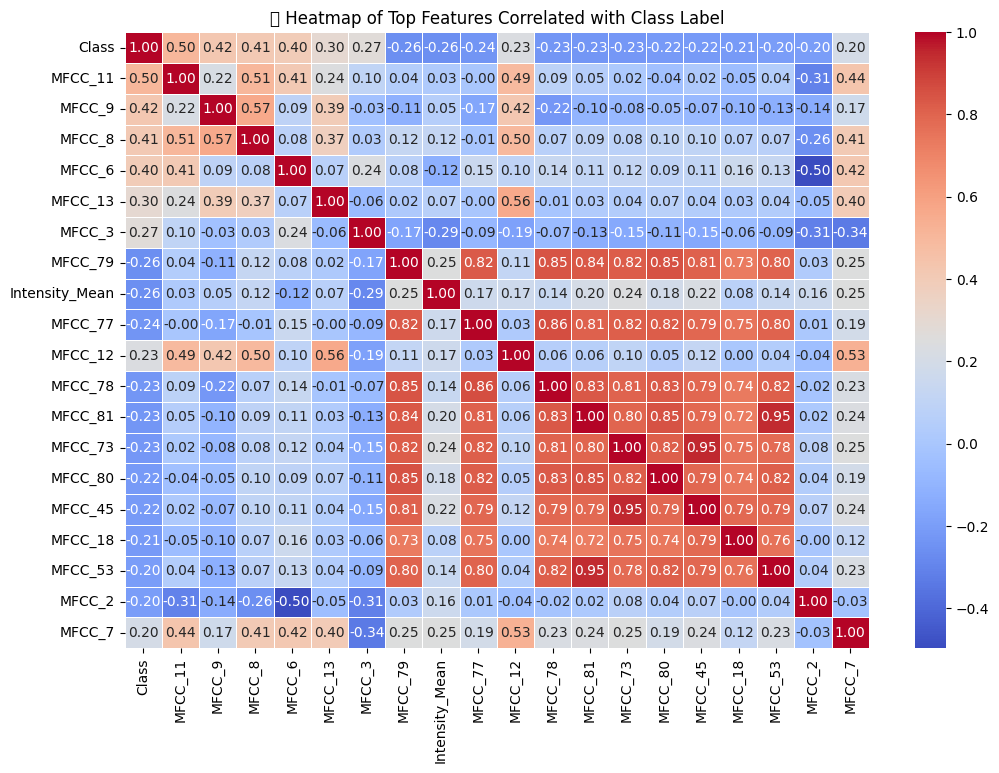

In [ ]:

# Compute Correlation with Class Label
correlation_matrix = df.corr()

# Select the Top 20 Most Correlated Features (Positive or Negative)
top_features = correlation_matrix["Class"].abs().sort_values(ascending=False).head(20).index

# Filter the correlation matrix for these top features
top_corr_matrix = correlation_matrix.loc[top_features, top_features]

# Plot Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(top_corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("🔥 Heatmap of Top Features Correlated with Class Label")
plt.show()


**HC**: 0  **PD**: 1

Feature selection

In [ ]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# Select Best 50 Features
selector = SelectKBest(mutual_info_classif, k=20)
X_selected = selector.fit_transform(X_scaled, y)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42,stratify=y)


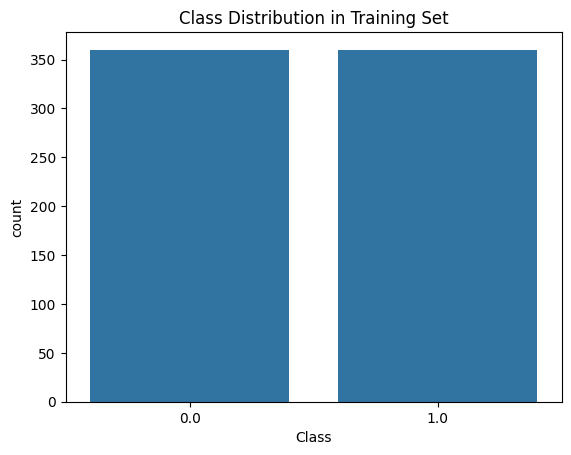

Class 0 Count: 360
Class 1 Count: 360


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=y_train)  # Visualize class distribution
plt.title("Class Distribution in Training Set")
plt.show()

print("Class 0 Count:", np.sum(y_train == 0))
print("Class 1 Count:", np.sum(y_train == 1))


Model Training

In [ ]:
# Define models
models = {
    "SVM": SVC(kernel="rbf", probability=True, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
}

# Train & Evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)  # Train model
    y_pred = model.predict(X_test)  # Predict test set
    y_pred_prob = model.predict_proba(X_test)[:, 1]  # Get probabilities for AUC-ROC

    # Print model performance
    print(f"\n🔥 {name} Model Performance:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_prob):.4f}")
    print(classification_report(y_test, y_pred))



🔥 SVM Model Performance:
Accuracy: 0.8944
AUC-ROC: 0.9478
              precision    recall  f1-score   support

         0.0       0.91      0.88      0.89        90
         1.0       0.88      0.91      0.90        90

    accuracy                           0.89       180
   macro avg       0.89      0.89      0.89       180
weighted avg       0.89      0.89      0.89       180


🔥 Random Forest Model Performance:
Accuracy: 0.9500
AUC-ROC: 0.9922
              precision    recall  f1-score   support

         0.0       0.97      0.93      0.95        90
         1.0       0.94      0.97      0.95        90

    accuracy                           0.95       180
   macro avg       0.95      0.95      0.95       180
weighted avg       0.95      0.95      0.95       180


🔥 XGBoost Model Performance:
Accuracy: 0.9500
AUC-ROC: 0.9932
              precision    recall  f1-score   support

         0.0       0.96      0.94      0.95        90
         1.0       0.95      0.96      0.95   

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:19:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Grid search (Hyperparameter tuning)

In [ ]:
# SVM Hyperparameters
svm_params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

# Random Forest Hyperparameters
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10]
}

# XGBoost Hyperparameters
xgb_params = {
    'learning_rate': [0.01, 0.1, 0.5],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7]
}


In [ ]:
# Define models
svm = SVC(probability=True, random_state=42)
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)

# Grid Search for SVM
svm_grid = GridSearchCV(svm, svm_params, cv=5, scoring='accuracy', n_jobs=-1)
svm_grid.fit(X_train, y_train)

# Grid Search for Random Forest
rf_grid = GridSearchCV(rf, rf_params, cv=5, scoring='accuracy', n_jobs=-1)
rf_grid.fit(X_train, y_train)

# Grid Search for XGBoost
xgb_grid = GridSearchCV(xgb, xgb_params, cv=5, scoring='accuracy', n_jobs=-1)
xgb_grid.fit(X_train, y_train)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:20:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.5],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

Evaluation

In [ ]:
# Best hyperparameters
print("\n🔥 Best SVM Parameters:", svm_grid.best_params_)
print("🔥 Best Random Forest Parameters:", rf_grid.best_params_)
print("🔥 Best XGBoost Parameters:", xgb_grid.best_params_)

# Evaluate Best Models
models = {
    "SVM": svm_grid.best_estimator_,
    "Random Forest": rf_grid.best_estimator_,
    "XGBoost": xgb_grid.best_estimator_
}

for name, model in models.items():
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]  # For AUC-ROC

    print(f"\n🔥 {name} Model Performance:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_prob):.4f}")
    print(classification_report(y_test, y_pred))



🔥 Best SVM Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'poly'}
🔥 Best Random Forest Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
🔥 Best XGBoost Parameters: {'learning_rate': 0.5, 'max_depth': 7, 'n_estimators': 100}

🔥 SVM Model Performance:
Accuracy: 0.9278
AUC-ROC: 0.9621
              precision    recall  f1-score   support

         0.0       0.93      0.92      0.93        90
         1.0       0.92      0.93      0.93        90

    accuracy                           0.93       180
   macro avg       0.93      0.93      0.93       180
weighted avg       0.93      0.93      0.93       180


🔥 Random Forest Model Performance:
Accuracy: 0.9444
AUC-ROC: 0.9938
              precision    recall  f1-score   support

         0.0       0.97      0.92      0.94        90
         1.0       0.93      0.97      0.95        90

    accuracy                           0.94       180
   macro avg       0.95      0.94      0.94       180
weighted avg      

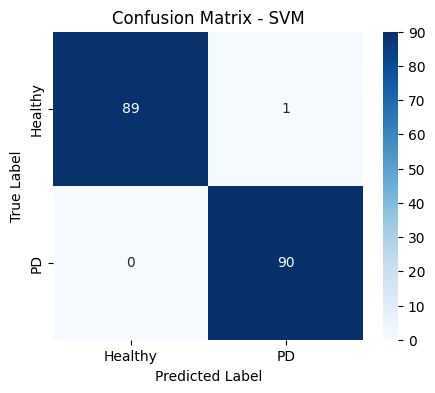

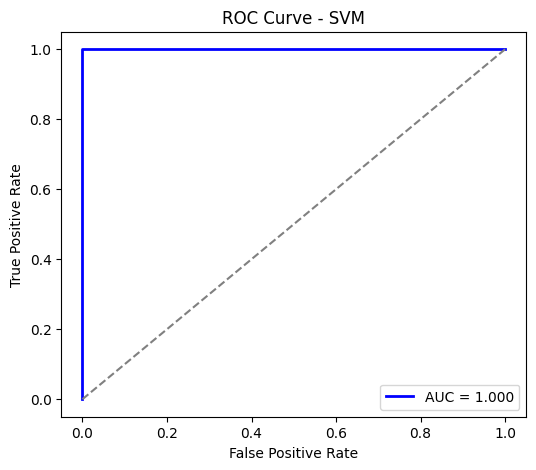

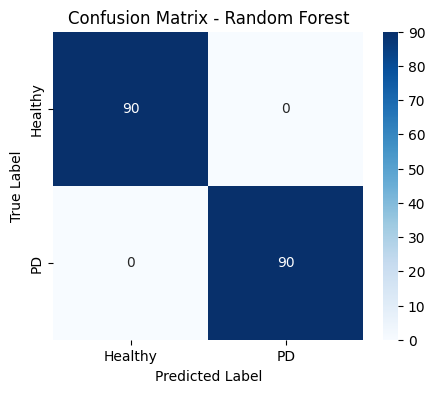

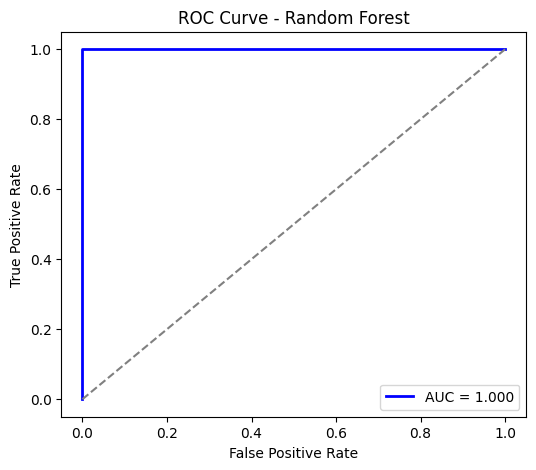

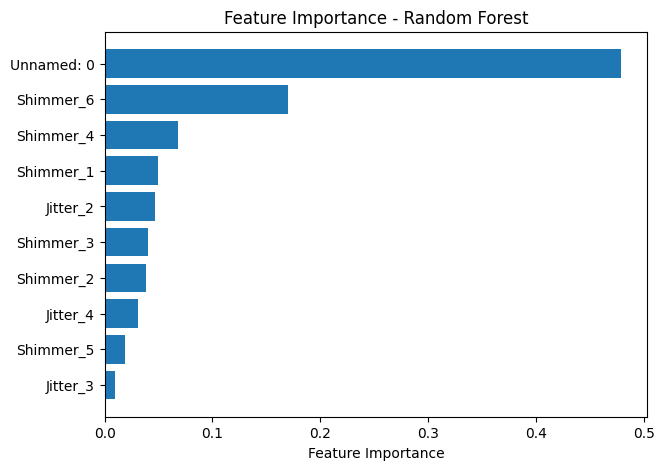

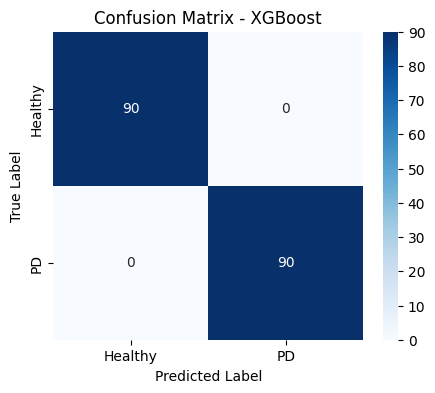

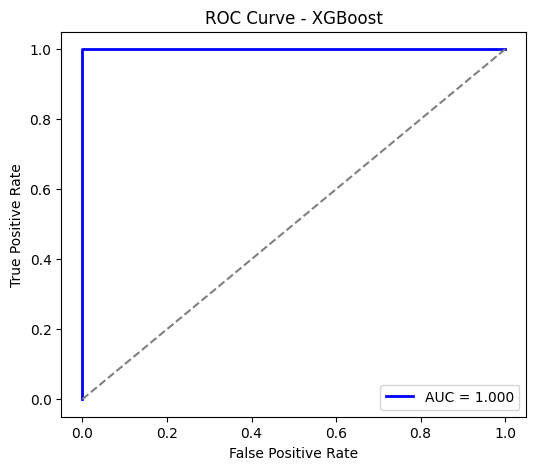

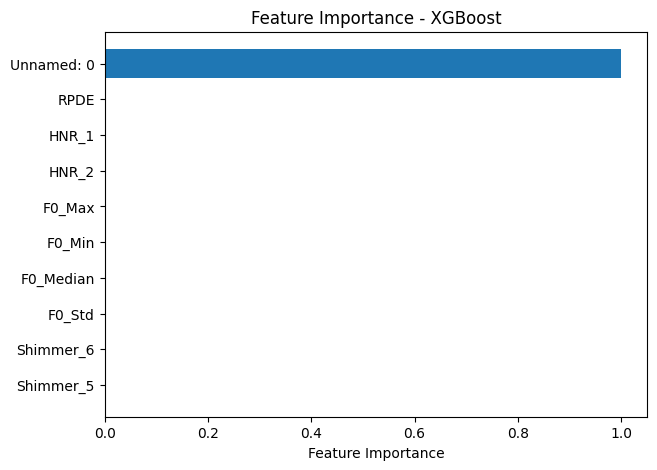

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve

# 🎯 Function to Plot Confusion Matrix
def plot_confusion_matrix(y_test, y_pred, model_name):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Healthy", "PD"], yticklabels=["Healthy", "PD"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

# 🎯 Function to Plot ROC Curve
def plot_roc_curve(y_test, y_pred_prob, model_name):
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color="blue", lw=2, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend(loc="lower right")
    plt.show()

# 🎯 Function to Plot Feature Importance (for RF & XGBoost)
def plot_feature_importance(model, feature_names, model_name):
    if hasattr(model, "feature_importances_"):  # Check if model supports feature importance
        importance = model.feature_importances_
        sorted_idx = importance.argsort()[-10:]  # Top 10 Features
        plt.figure(figsize=(7, 5))
        plt.barh(range(10), importance[sorted_idx], align="center")
        # Use feature_names directly instead of X_train.columns
        plt.yticks(range(10), [feature_names[i] for i in sorted_idx])
        plt.xlabel("Feature Importance")
        plt.title(f"Feature Importance - {model_name}")
        plt.show()

# 🏆 Apply to Each Model
for name, model in models.items():
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]  # For ROC Curve

    plot_confusion_matrix(y_test, y_pred, name)
    plot_roc_curve(y_test, y_pred_prob, name)

    if name in ["Random Forest", "XGBoost"]:  # Feature importance only for these models
        # Pass the original feature names (from 'X' before scaling) to the function
        plot_feature_importance(model, X.columns, name)